In [1]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

e:\Installation\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
e:\Installation\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

df = read_excel('../../Data/Processed data/lstm_dmc.xlsx')

In [3]:
# convert Date field to float
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].values.astype(float)
#sort by date
df = df.sort_values(by='Date')
# for rows where df['Affected'] is null or non-numeric, replace with 0
df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
df.reset_index(drop=True, inplace=True)

In [4]:
df.shape

(698, 2)

In [5]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
input_size = 14
prediction_window = 5
window_size = input_size + prediction_window
hidden_size = 64
num_layers = 1


print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  19  input_size:  14  num_layers:  1


In [6]:
def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples

samples = create_time_series_samples(df, window_size)

In [7]:
affected_df = pd.DataFrame([sample['Affected'].values for sample in samples])
affected_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,92.0,82.0,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0
1,82.0,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0,35.0
2,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0,35.0,19.0
3,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0,35.0,19.0,36.0
4,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0,35.0,19.0,36.0,37.0


In [8]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(affected_df, 0.8, False)

In [9]:
def split_X_y(df):
    #last prediction_window columns are y
    y = df.iloc[:, -prediction_window:]
    #first window_size - prediction_window columns are X
    X = df.iloc[:, :input_size]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [10]:
print("X_train.shape: ", X_train.shape, " y_train.shape: ", y_train.shape, " X_test.shape: ", X_test.shape, " y_test.shape: ", y_test.shape)

X_train.shape:  (544, 14)  y_train.shape:  (544, 5)  X_test.shape:  (136, 14)  y_test.shape:  (136, 5)


In [11]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, prediction_window)  

    def forward(self, x):
        h_t, _ = self.lstm(x)
        output = self.fc(h_t[:, -1, :]) 
        return output

In [13]:
model = LSTMModel(input_size, hidden_size, num_layers)

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
train_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses[epoch] = loss.item()

Epoch [1/500], Loss: 417.1169
Epoch [2/500], Loss: 502.1566
Epoch [3/500], Loss: 549.6661
Epoch [4/500], Loss: 324.3885
Epoch [5/500], Loss: 516.2729
Epoch [6/500], Loss: 234.6530
Epoch [7/500], Loss: 543.1588
Epoch [8/500], Loss: 301.5496
Epoch [9/500], Loss: 334.4739
Epoch [10/500], Loss: 388.7752


Epoch [11/500], Loss: 329.9768
Epoch [12/500], Loss: 278.4308
Epoch [13/500], Loss: 282.0740
Epoch [14/500], Loss: 728.7387
Epoch [15/500], Loss: 653.9310
Epoch [16/500], Loss: 62.5949
Epoch [17/500], Loss: 406.6696
Epoch [18/500], Loss: 323.0701
Epoch [19/500], Loss: 460.3011
Epoch [20/500], Loss: 181.5786
Epoch [21/500], Loss: 102.0484
Epoch [22/500], Loss: 361.8048
Epoch [23/500], Loss: 180.1179
Epoch [24/500], Loss: 328.5632
Epoch [25/500], Loss: 317.2569
Epoch [26/500], Loss: 145.1926
Epoch [27/500], Loss: 444.3463
Epoch [28/500], Loss: 182.9612
Epoch [29/500], Loss: 297.9697
Epoch [30/500], Loss: 259.4903
Epoch [31/500], Loss: 274.5339
Epoch [32/500], Loss: 248.9148
Epoch [33/500], Loss: 427.9223
Epoch [34/500], Loss: 372.9070
Epoch [35/500], Loss: 485.0174
Epoch [36/500], Loss: 252.1153
Epoch [37/500], Loss: 253.4550
Epoch [38/500], Loss: 344.0472
Epoch [39/500], Loss: 328.1426
Epoch [40/500], Loss: 209.5672
Epoch [41/500], Loss: 284.2525
Epoch [42/500], Loss: 240.4257
Epoch [43

In [16]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

predictions = test_outputs.numpy()

Test Loss: 409.0578


In [17]:
#get the first column of the test set
y_test_1 = y_test[:, 0]
# y_test_2 = y_test[:, 1]
# y_test_3 = y_test[:, 2]

# #get the first column of the predictions
predictions_1 = predictions[:, 0]
# predictions_2 = predictions[:, 1]
# predictions_3 = predictions[:, 2]

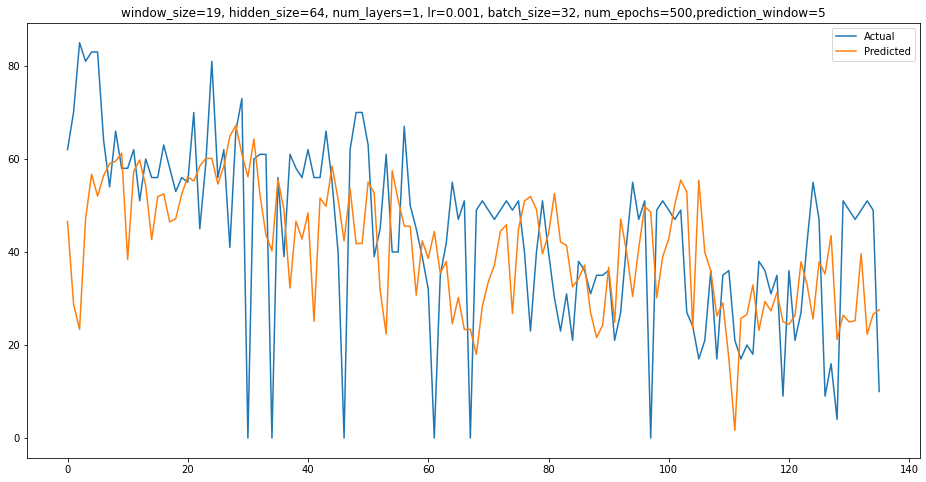

In [18]:
plt.figure(figsize=(16,8))
plt.title(f'window_size={window_size}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs},prediction_window={prediction_window}')
plt.plot(y_test_1, label='Actual')
plt.plot(predictions_1, label='Predicted')
plt.legend()
plt.show()

In [19]:
# MAE, MSE, RMSE losses
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_1, predictions_1)
mse = mean_squared_error(y_test_1, predictions_1)
rmse = np.sqrt(mse)
print("MAE: ", mae, " MSE: ", mse, " RMSE: ", rmse)

MAE:  14.919800643535222  MSE:  367.3835253332022  RMSE:  19.167251376585067
